In [37]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from operator import attrgetter
import matplotlib.colors as mcolors

In [2]:
#Disponible en https://archive.ics.uci.edu/dataset/352/online+retail
data = pd.read_excel('Online Retail.xlsx')
data.sample(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
108547,545545,21668,RED STRIPE CERAMIC DRAWER KNOB,2,2011-03-03 15:02:00,1.25,17841.0,United Kingdom
155366,549984,22558,CLOTHES PEGS RETROSPOT PACK 24,12,2011-04-13 15:57:00,1.65,15147.0,United Kingdom
184290,552681,85099B,JUMBO BAG RED RETROSPOT,3,2011-05-10 15:08:00,4.13,NaN,United Kingdom
175985,551995,35095A,BLUE VICTORIAN FABRIC OVAL BOX,1,2011-05-05 15:42:00,0.83,NaN,United Kingdom
17509,537765,20735,BLACK MINI TAPE MEASURE,4,2010-12-08 12:08:00,0.85,14606.0,United Kingdom


# Análisis exploratorio

In [4]:
df_eda = data.copy()

# Información de las columnas
df_eda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


## Calidad de los datos

Total de datos nulos por característica: 
InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64
Proporción de datos nulos por variable


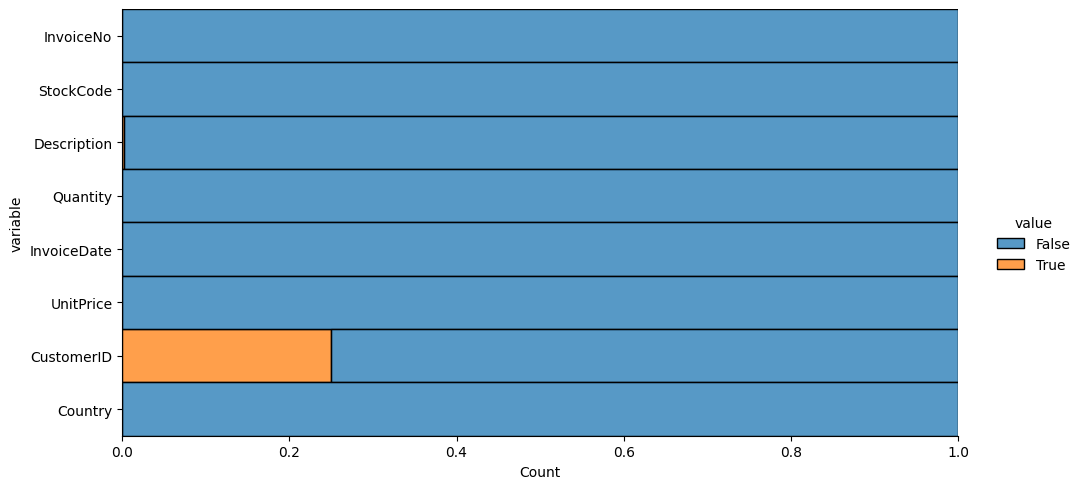

Ubicación de los datos nulos


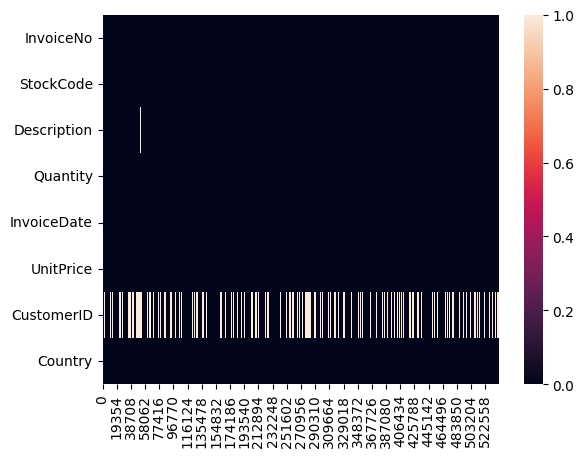

Distribución de los datos nulos


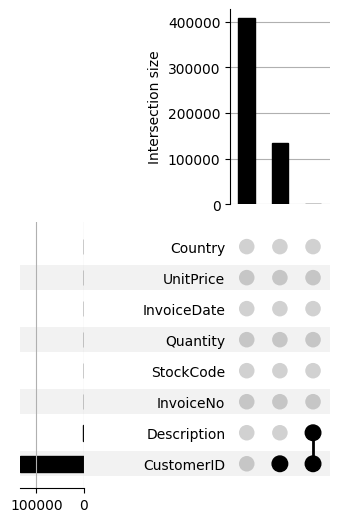

In [34]:
#Total de nulos
print(f"Total de datos nulos por característica: \n{data.isnull().sum()}")

#Proporción de datos nulos por variable
df_eda.isnull().melt().pipe(lambda df: (sb.displot(data = df, y = 'variable', hue = 'value', multiple = 'fill', aspect = 2)))
print("Proporción de datos nulos por variable")
plt.show()

#Ubicación de los datos nulos
df_eda.isnull().transpose().pipe(lambda df: (sb.heatmap(data = df)))
print("Ubicación de los datos nulos")
plt.show()

# Distribución de los datos nulos
%run pandas-missing-extension.ipynb 
df_eda.missing.missing_upsetplot()
print("Distribución de los datos nulos")
plt.show()


## Análisis univariante y outliers

In [23]:
print(f"Número de transacciones únicas: ",df_eda['InvoiceNo'].unique().size)
print(f"Número de clientes únicos: ",df_eda['CustomerID'].unique().size)
print(f"Número de productos únicos: ",df_eda['StockCode'].unique().size)

#df_eda['InvoiceNo'].value_counts()

Número de transacciones únicas:  25900
Número de clientes únicos:  4373
Número de productos únicos:  4070


In [27]:
# Cuartiles y medidas de tendencia central de los datos.
print(f" Variables numéricas: \n {df_eda.describe().T}")
print("\n:---------------------------------------------------:\n")
print(f"Variables categóricas: \n {df_eda.describe(include = 'object').T}")

 Variables numéricas: 
                 count                           mean                  min  \
Quantity     541909.0                        9.55225             -80995.0   
InvoiceDate    541909  2011-07-04 13:34:57.156386048  2010-12-01 08:26:00   
UnitPrice    541909.0                       4.611114            -11062.06   
CustomerID   406829.0                    15287.69057              12346.0   

                             25%                  50%                  75%  \
Quantity                     1.0                  3.0                 10.0   
InvoiceDate  2011-03-28 11:34:00  2011-07-19 17:17:00  2011-10-19 11:27:00   
UnitPrice                   1.25                 2.08                 4.13   
CustomerID               13953.0              15152.0              16791.0   

                             max          std  
Quantity                 80995.0   218.081158  
InvoiceDate  2011-12-09 12:50:00          NaN  
UnitPrice                38970.0    96.759853  
Custome

**Problemas de calidad en los datos**
- La característica Quantity tiene valores negativos que no tienen sentido físico. 
- La característica UnitPrice tiene valores negativos que no tienen sentido físico. 
- Existen valores atípicos en UnitPrice, el cuartil 75 está marcado por $4.13 y su valor máximo es 38970.0 lo cual refleja un posible error en el precio. Apoyado en que la media es de $4.61. Lo mismo ocurre para la variable UnitPrice

In [68]:
# Separa variables categóricas de numéricas.
numeric_columns = df_eda.select_dtypes(include=['int64', 'float64']).columns.tolist()
categoric_columns = df_eda.select_dtypes(include='object').columns.tolist()

In [62]:
# Categóricas
for serie in categoric_columns:
    top_5 = df_eda[serie].value_counts(normalize=True).sort_values(ascending=False).head(5) * 100
    bottom_5 = df_eda[serie].value_counts(normalize=True).sort_values(ascending=False).tail(5) * 100

    print(f"Top 5 values for {serie}:\n{top_5}\n")
    print(f"Bottom 5 values for {serie}:\n{bottom_5}\n")
    print(":----------------------------------------------------:\n")

Top 5 values for InvoiceNo:
InvoiceNo
573585    0.205570
581219    0.138215
581492    0.134893
580729    0.133048
558475    0.130096
Name: proportion, dtype: float64

Bottom 5 values for InvoiceNo:
InvoiceNo
559414     0.000185
C559417    0.000185
536866     0.000185
563934     0.000185
C558901    0.000185
Name: proportion, dtype: float64

:----------------------------------------------------:

Top 5 values for StockCode:
StockCode
85123A    0.426824
22423     0.406526
85099B    0.398406
47566     0.318688
20725     0.302449
Name: proportion, dtype: float64

Bottom 5 values for StockCode:
StockCode
90184c    0.000185
85034b    0.000185
90183c    0.000185
84971l    0.000185
72759     0.000185
Name: proportion, dtype: float64

:----------------------------------------------------:

Top 5 values for Description:
Description
WHITE HANGING HEART T-LIGHT HOLDER    0.438334
REGENCY CAKESTAND 3 TIER              0.407064
JUMBO BAG RED RETROSPOT               0.399478
PARTY BUNTING             

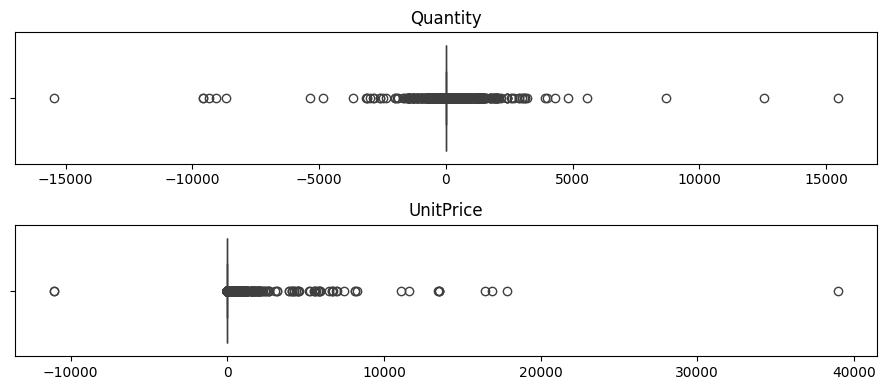

In [25]:
# Diagrama de cajas
fig, axs = plt.subplots(2, 1, figsize=(9, 4))
sb.boxplot(ax = axs[0], data = df_eda, x = "Quantity")
axs[0].set_title("Quantity")
axs[0].set_xlabel('')


sb.boxplot(ax = axs[1], data = df_eda, x = "UnitPrice")
axs[1].set_title("UnitPrice")
axs[1].set_xlabel('')
plt.tight_layout()
plt.show()

# Limpieza de los datos : manejo de nulos y datos atípicos

In [8]:
# Crear una copia del DataFrame para aplicar los filtros
df_filtrado = data.copy()

# Elimina transacciones que se cancelaron
df_filtrado = df_filtrado[~df_filtrado['InvoiceNo'].str.startswith('c', na=False)]

# Columnas con outliers a tratar
columnas_a_filtrar = ["UnitPrice","Quantity"]  

#Elimina valores negativos
df_filtrado = df_filtrado[df_filtrado["UnitPrice"] >= 0]
df_filtrado = df_filtrado[df_filtrado["Quantity"] >= 0]

# Elimina valores atípicos
for columna in columnas_a_filtrar:
    # Calcular el primer y tercer cuartil (Q1 y Q3)
    Q1 = df_filtrado[columna].quantile(0.25)
    Q3 = df_filtrado[columna].quantile(0.75)
    
    # Calcular el rango intercuartílico (IQR)
    IQR = Q3 - Q1
    
    # Definir los límites para los valores atípicos
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Filtrar el DataFrame para eliminar las filas con valores atípicos
    df_filtrado = df_filtrado[(df_filtrado[columna] >= lower_bound) & (df_filtrado[columna] <= upper_bound)]

# Mostrar el DataFrame filtrado
print(df_filtrado)


       InvoiceNo StockCode                          Description  Quantity  \
0         536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1         536365     71053                  WHITE METAL LANTERN         6   
2         536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3         536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4         536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
...          ...       ...                                  ...       ...   
541904    581587     22613          PACK OF 20 SPACEBOY NAPKINS        12   
541905    581587     22899         CHILDREN'S APRON DOLLY GIRL          6   
541906    581587     23254        CHILDRENS CUTLERY DOLLY GIRL          4   
541907    581587     23255      CHILDRENS CUTLERY CIRCUS PARADE         4   
541908    581587     22138        BAKING SET 9 PIECE RETROSPOT          3   

               InvoiceDate  UnitPrice  CustomerID         Country  
0      

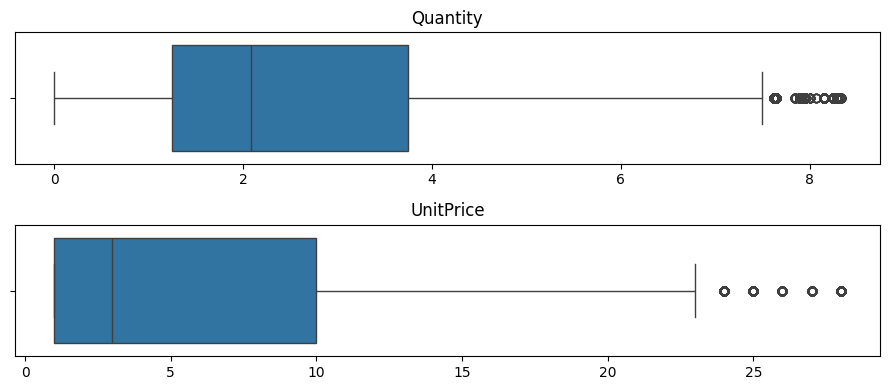

In [4]:
# Diagrama de cajas
fig, axs = plt.subplots(2, 1, figsize=(9, 4))
sb.boxplot(ax = axs[0], data = df_filtrado, x = "UnitPrice")
axs[0].set_title("Quantity")
axs[0].set_xlabel('')


sb.boxplot(ax = axs[1], data = df_filtrado, x = "Quantity")
axs[1].set_title("UnitPrice")
axs[1].set_xlabel('')
plt.tight_layout()
plt.show()

In [10]:
# Recupera información de clientes y descripción de productos.

# Recupera información de una característica desde otra igual cuya entrada esté completa.
def fill_missing_features(df, feature1, feature2):
    # Crea un diccionario que mapea feature2 a feature1 no nulos
    invoice_to_customer = df.dropna(subset=[feature1]).set_index(feature2)[feature1].to_dict()
    
    # Llena los valores nulos desde el diccionario los valores nulos
    df[feature1] = df.apply(lambda row: invoice_to_customer.get(row[feature2], row[feature1]) 
                                if pd.isnull(row[feature1]) else row[feature1], axis=1)
    
    return df


# Completa Customer ID y Description a patir de InvoiceNo y StockCode respectivamente
df_filtrado = fill_missing_features(df_filtrado,"CustomerID","InvoiceNo")
df_filtrado = fill_missing_features(df_filtrado,"Description","StockCode")


Ubicación de los datos nulos


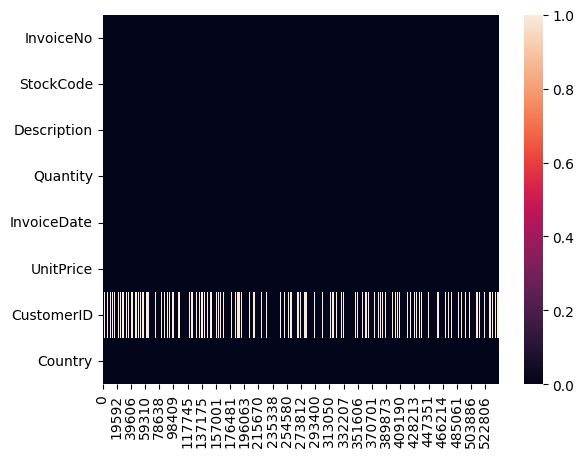

In [11]:
df_filtrado.isnull().transpose().pipe(lambda df: (sb.heatmap(data = df)))
print("Ubicación de los datos nulos")
plt.show()

In [14]:
# Elimina los faltantes que no se pudieron imputar
df_filtrado.dropna(inplace=True, how="any")

#Elimina las entradas duplicadas
df_filtrado.drop_duplicates()
print(df_filtrado.info())

<class 'pandas.core.frame.DataFrame'>
Index: 349872 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    349872 non-null  object        
 1   StockCode    349872 non-null  object        
 2   Description  349872 non-null  object        
 3   Quantity     349872 non-null  int64         
 4   InvoiceDate  349872 non-null  datetime64[ns]
 5   UnitPrice    349872 non-null  float64       
 6   CustomerID   349872 non-null  float64       
 7   Country      349872 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 24.0+ MB
None


# Análisis de cohortes

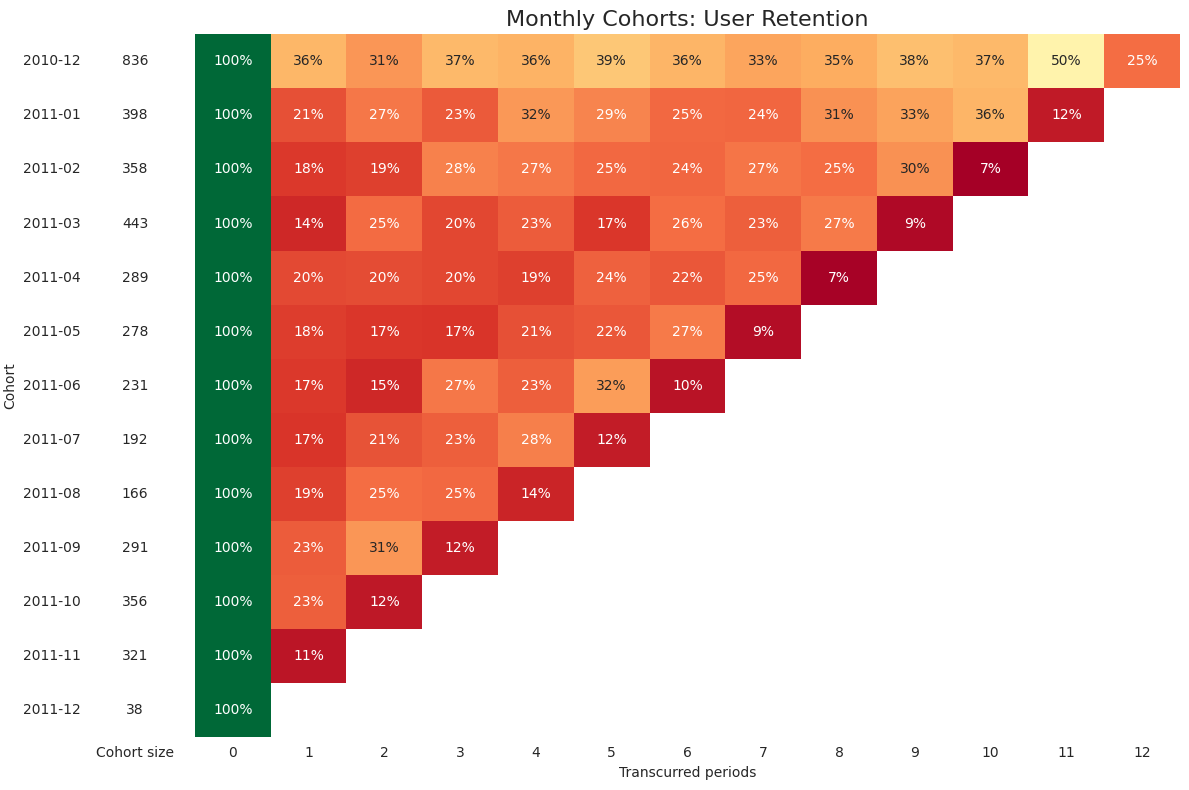

In [43]:
df_cohorte = df_filtrado.copy()

# Extrae el mes y año de cada compra. 
df_cohorte['OrderMonth'] = df_cohorte['InvoiceDate'].dt.to_period('M')

# Agrupa por cliente y le asigna una cohorte dada su primer registro de compra. 
df_cohorte['Cohort'] = df_cohorte.groupby('CustomerID')['InvoiceDate'].transform('min').dt.to_period('M')

# Cuenta el número de usuarios de cada cohorte que compraron en cada periodo "OrderMonth"
df_cohorte = df_cohorte.groupby(['Cohort', 'OrderMonth']).agg(CustomerCount=('CustomerID', 'nunique')).reset_index(drop=False)

# Agrega el número de periodos transcurridos entre la cohorte y el mes de la compra 
df_cohorte['Period'] = (df_cohorte.OrderMonth - df_cohorte.Cohort).apply(attrgetter('n'))

# Agrega información en un df pivoteado 
df_pivoteado = df_cohorte.pivot_table(index='Cohort', columns='Period', values='CustomerCount')


# Grafica 
cohorte_size = df_pivoteado.iloc[:, 0]
matriz_retencion = df_pivoteado.divide(cohorte_size, axis=0)

with sb.axes_style("white"):
    fig, ax = plt.subplots(1, 2, figsize=(12, 8), sharey=True, gridspec_kw={'width_ratios': [1, 11]})
    
    # Matriz de retención
    sb.heatmap(matriz_retencion, 
                mask=matriz_retencion.isnull(), 
                annot=True, 
                fmt='.0%', 
                cmap='RdYlGn', 
                cbar= False,
                ax=ax[1])
    ax[1].set_title('Monthly Cohorts: User Retention', fontsize=16)
    ax[1].set(xlabel='Transcurred periods',
              ylabel='')

    # Tamaño de las cohortes
    df_cohorte_size = pd.DataFrame(cohorte_size).rename(columns={0: 'Cohort size'})
    white_cmap = mcolors.ListedColormap(['white'])
    sb.heatmap(df_cohorte_size, 
                annot=True, 
                cbar=False, 
                fmt='g', 
                cmap=white_cmap, 
                ax=ax[0])

    fig.tight_layout()

Durante el primer mes se evidencia una caída promedio del 80% de los clientes que compran, a excepción de la primera corte analizada; 2010-12, la cual mantiene un 36% de clientes y es el conjunto que mejor se comporta. A lo largo de la matriz, podemos ver fluctuaciones en la retención a lo largo del tiempo. Esto podría deberse a las características del negocio que al ser items únicos, los clientes realizan compras periódicas, seguidas de periodos de inactividad. Sin embargo, a partir de los datos por sí solos, esto es muy difícil de explicar con precisión.